# Installations

# Imports

In [149]:
import io
import os
%matplotlib inline
import matplotlib.pyplot as plt

# data management
import xarray as xr
import numpy as np
import pandas as pd

# Azure Connectivity
import getpass
import azure.storage.blob
from azure.storage.blob import BlobClient

# utilities
import time
import urllib.parse
from random import randint


### Function to download a specified file

In [6]:
def download_file(sas_url, filename, overwrite_local_file):
    """
    Downloads the specified file from Azure blob storage
    If asked to not overwrite, then first checks if the file is available locally and does not download again in that case.
    - sas_url   : url complete with sas token
    - filename  : name of the downloaded file
    - overwrite_local_file : if True, will overwrite, else, if already available locally, will not download again.
    Returns:  None
    """
    if overwrite_local_file or not (os.path.isfile(filename)):        
        blob_client = BlobClient.from_blob_url(sas_url)
        with open(filename, "wb") as my_blob:
            download_stream = blob_client.download_blob()
            my_blob.write(download_stream.readall())

                  

### Function to aggregate average results from multiple pre-processed results

In [2]:
def AggregateAverageForRange(start_year, end_year, cmip=6, result_type='max'
                           , azure_url_prefix=None, sas_token=None
                           , overwrite_local_file=False, remove_after_use=True):
    """
    Makes available Average and Record temperatures for multiple decades. 
    * Date range should be a multiple of decades --- e.g. 1950 to 1969  OR 1951 to 1970.
    * Make sure the underlying data files, by decades are available. Else, an exception will be raised!
    
    Checks the preprocessed average data files in Azure cloud or locally and:
    * downloads the matching file if already exists
    * else, checks for the component files (by decade). 
    * -- If complete data not available, exception is thrown. Else, the required files are downloaded and aggregated.
    * returns the results xarray dataset
    Average and Record temperatures are captured for each cell, i.e. the lat, lon combination in the specified grid.
    The units of temperature (degree Kelvin) are preserved.
    Input Parameters:
    - start_year  : start year of the range
    - end_year    : end year of the range
    - cmip        : integer number to specify cmip version (5 or 6 or other). Default is 6
    - result_type : string 'max' or 'min'
    - azure_url_prefix=None : if downloading from Azure blob storage, specify the url with the container and the folder
                              , else specify None to check the files locally.
    - sas_token   : A sas token with 'read' permissions to the azure blob container
    - overwrite_local_file  : if True, will overwrite, else, if already available locally, will not download again.
    - remove_after_use      : default = True. Set to False to retain the files locally
    Returns:  The xarray dataframe with 'results'
    """
    validations_passed = False
    ds_results = None
    filename = ''
    
    n_years = (end_year - start_year) + 1   # range
    
    # validations
    if not (isinstance(start_year, int) and isinstance(end_year, int) and (end_year > start_year)):
        print('Validation Error: start_year and end_year should be integers; end year should be greater than start year.')
    elif not isinstance((n_years)%10, int):
        print('Validation Error: The total range (end year - start year)+1 should be a multiple of 10.')    
    else:
        validations_passed = True
    
    if validations_passed:
        n_components = int(n_years / 10)             # number of decades in the range       
        total_years = 0                    
        
        # intended filename
        filename = 'Avg_temp_{}_CMIP{}__{}_yrs__{}_to_{}.nc'.format(result_type
                                                                 ,cmip
                                                                 ,n_years
                                                                 ,start_year
                                                                 ,end_year)
        # intended component filenames
        component_files = [''] * n_components   # as many component files as many decades in the range
        component_available = [False] * n_components   # initialized as none of the files are available
        complete_data = False                   # initialized as file / components are not available
        
        component_start_year = start_year  
        for i in range(n_components):
            component_end_year = component_start_year + 9
            component_files[i] = 'Avg_temp_{}_CMIP{}__{}_yrs__{}_to_{}.nc'.format(result_type
                                                                 ,cmip,10,component_start_year,component_end_year)
            component_start_year += 10

        # prepare to time the operation
        start_time = time.time()
        
        # if local storage is to be checked first
        if azure_url_prefix is None or overwrite_local_file==False:
            if os.path.exists(filename):                # if the complete file exists
                complete_data = True                
            else:
                # check each file exists
                for i in range(n_components):
                    component_available[i] = os.path.exists(component_files[i])
                    
                complete_data = all(component_available)

        # if complete data is not available locally, check if we can look in Azure blob storage
        if not complete_data:
            if azure_url_prefix is not None:
                # check in azure
                # first the complete file...
                sas_url = azure_url_prefix + filename + "?" + sas_token
                blob_client = BlobClient.from_blob_url(sas_url)
                if blob_client.exists():
                    download_file(sas_url, filename, overwrite_local_file)
                    complete_data = True
                else:
                    for i in range(n_components):
                        # only for files not availble locally, unless overwrite_local_file = True
                        if not component_available[i] or overwrite_local_file:
                            sas_url = azure_url_prefix + component_files[i] + "?" + sas_token
                            blob_client = BlobClient.from_blob_url(sas_url)
                            if blob_client.exists():
                                download_file(sas_url, component_files[i], overwrite_local_file)
                            else:
                                errMsg = 'Missing component file (on Azure){}'.format(component_available[i])
                                raise ValueError(errMsg)
                    complete_data = True    

                
            else: 
                errMsg = 'Missing component files (locally): {}'.format(', '.join([str(component_files[i]) for i,bv in enumerate(component_available) if bv]))
                raise ValueError(errMsg)


        # complete files should be available locally at this stage
        # start by checking for the complete file first
        if os.path.exists(filename):
            ds_results = xr.open_dataset(filename)  # load the complete file directly
            total_year = n_years
            # delete the file
            if remove_after_use:
                os.remove(filename)
        else:
            # prepare from component files            
            for cfilename in component_files:
                if total_years == 0:    # first file
                    ds_results = xr.open_dataset(cfilename)                    
                else:
                    ds_comp = xr.open_dataset(cfilename)
                    result_variables = ds_results.attrs['Data variables']
                    if remove_after_use:
                        os.remove(cfilename)
                    if result_type == "min":        
                        ds_results.update({result_variables[1] : xr.ufuncs.minimum(ds_comp[result_variables[1]]
                                                                                , ds_results[result_variables[1]])})   # peak min temperature across years
                    else:
                        ds_results.update({result_variables[1] : xr.ufuncs.maximum(ds_comp[result_variables[1]]
                                                                                , ds_results[result_variables[1]])})   # peak max temperature across years
                    # for both max and min
                    ds_results.update({result_variables[0] : (ds_results[result_variables[0]] + ds_comp[result_variables[1]])})    # sum across years
                # in any case    
                total_years += 10
            # finally, for avg from component files        
            ds_results.update({result_variables[0] : np.round((ds_results[result_variables[0]] / n_components), 2)})    # avg across years
            ds_results.update({result_variables[1] : np.round(ds_results[result_variables[1]], 2)})    # round off values

        # set attributes
        ds_results.attrs['Range'] = str(n_years) + ' years'
        ds_results.attrs['Start year'] = str(start_year)
        ds_results.attrs['End year'] = str(end_year)
        ds_results.attrs['Years processed'] = total_years
        ds_results.attrs['Store as'] = 'Avg_temp_{}_CMIP{}__{}_yrs__{}_to_{}'.format(result_type
                                                                               ,cmip, n_years, start_year, end_year)
            
        # print out the time it took
        execution_time = (time.time() - start_time)
        print("Complete execution time | AggregateAverageForRange | (mins) {:0.2f}".format(execution_time/60.0))
            
    return ds_results

### Call Aggregate Results to get a range of multiple decades

In [7]:
url_prefix = 'https://nexdcp30.blob.core.windows.net/cmip5/averages/'  # without the name of the file at the end

#Insert your Azure SAS token here in order to pull files from Blob storage container
sas_token = 
ds_results = AggregateAverageForRange(1950, 1959, cmip=5, result_type='max'
                           , azure_url_prefix=url_prefix, sas_token=sas_token
                           , overwrite_local_file=True, remove_after_use=False)

Complete execution time | AggregateAverageForRange | (mins) 1.76


In [10]:
ds_results

<xarray.Dataset>
Dimensions:    (lat: 720, lon: 1440, day: 365)
Coordinates:
  * lat        (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon        (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * day        (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
Data variables:
    tasmaxavg  (day, lat, lon) float32 ...
    tasmaxrec  (day, lat, lon) float32 ...
Attributes:
    Dataset:           Average temperature CMIP5
    About dataset:     A dataset with average and record temparatures, across...
    Original values:   tasmax
    Data variables:    ['tasmaxavg', 'tasmaxrec']
    Data description:  Average and record maximum temperature, based on tasmax
    Range:             10 years
    Start year:        1950
    End year:          1959
    Years processed:   0
    Store as:          Avg_temp_max_CMIP5__10_yrs__1950_to_1959

In [174]:
def calculate_average_for_region(ds_for_region):
    """
    Takes in an xarray dataset that represents a region, over a specific time dimension 
    and reduces all of the cells in the region, for each time period, to a single 
    average value. The individual lat, lon grids for each time period become 
    a single average value.
    Input Parameters:
    - ds_for_region  : xarray dataframe 
    Returns:  The xarray dataset 'ds_for_region' that contains the average of the values across the entire region. 
    """
    
    num_of_lats = len(ds_for_region.coords['lat'].values)
    num_of_lons = len(ds_for_region.coords['lon'].values)
    
    total_cells_in_region = num_of_lats * num_of_lons
    
    return ds_for_region.sum(dim='lat').sum(dim='lon').apply(lambda x: x / total_cells_in_region)

In [54]:
def convert_kelvin_to_celsius(temp: float) -> float:
    """
    Converts Kelvin temperature to Celcius
    Input Parameters:
    - temp  : float
    Returns: float celsius value 
    """
    return temp - 273.15

In [55]:
def convert_kelvin_to_fahrenheit(temp: float) -> float:
    """
    Converts Kelvin temperature to Fahrenheit
    Input Parameters:
    - temp  : float
    Returns: float fahrenheit value 
    """
    return (temp - 273.15)*(9/5) + 32

In [175]:
def get_region_and_generate_average(ds, start_lat: float, end_lat: float, start_lon: float, end_lon: float, outputUnits: str = 'K'):
    """
    Takes in an xarray dataset that represents a region, over a specific time dimension 
    and reduces all of the cells in the region, for each time period, to a single 
    average value. The individual lat, lon grids for each time period become 
    a single average value.
    Input Parameters:
    - ds  : xarray dataframe 
    - start_lat  : float starting latitude of region
    - end_lat  : float ending latitude of region
    - start_lon  : float starting lonitude of region
    - end_lon  : float endinging lonitude of region
    - outputUnits  : string desired output units
    Returns:  The xarray dataset 'ds_avg_region' that contains the average of the values across the entire region converted to desired units. 
    """
    
    ACCEPTED_UNITS = ["C", "F", "K"]
    desiredUnits = outputUnits.upper()
    
    # Baseline Checks to make sure Inputs are reasonable
    if start_lat >= end_lat:
        raise Exception("CoordinateException: start_lat must be smaller than end_lat")
    if start_lon >= end_lon:
        raise Exception("CoordinateException: start_lon must be smaller than end_lon")
    
    if desiredUnits in ACCEPTED_UNITS:
        # Slice the region of interest out of your Dataset
        ds_avg_region = calculate_average_for_region(ds.sel(lat=slice(start_lat, end_lat), lon=slice(start_lon, end_lon)))
        
        # Dataset is as small as possible so now it is time for unit conversion
        if desiredUnits == ACCEPTED_UNITS[0]:
            ds_avg_region = ds_avg_region.map(convert_kelvin_to_celsius)
        elif desiredUnits == ACCEPTED_UNITS[1] :
            ds_avg_region = ds_avg_region.map(convert_kelvin_to_fahrenheit)
    else:
        raise Exception("InvalidOutputUnitsException: must be one of: " + ", ".join(ACCEPTED_UNITS))
    
    return ds_avg_region
       

## Now that functions are implemented Inspect the Averages To make sure they are accurate

In [150]:
RANDOM_DAY_INDEX = randint(0, 365)
RANDOM_DAY_INDEX

248

In [127]:
ds_avg_region = get_region_and_generate_average(ds_results, 47.25, 48.12, 237.68, 238.44, outputUnits="k")
ds_avg_region

<xarray.Dataset>
Dimensions:    (day: 365)
Coordinates:
  * day        (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
Data variables:
    tasmaxavg  (day) float32 278.8 278.4 279.3 279.2 ... 279.3 278.7 278.7 278.8
    tasmaxrec  (day) float32 282.5 282.2 283.1 283.9 ... 282.1 280.9 280.8 281.7

In [151]:
ds_avg_region['tasmaxavg'][RANDOM_DAY_INDEX]

<xarray.DataArray 'tasmaxavg' ()>
array(295.99478, dtype=float32)
Coordinates:
    day      int64 249

In [141]:
ds_avg_region_test = ds_results.sel(lat=slice(47.25, 48.12), lon=slice(237.68, 238.44))
ds_avg_region_test

<xarray.Dataset>
Dimensions:    (lat: 3, lon: 3, day: 365)
Coordinates:
  * lat        (lat) float32 47.38 47.62 47.88
  * lon        (lon) float32 237.9 238.1 238.4
  * day        (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
Data variables:
    tasmaxavg  (day, lat, lon) float32 280.5 278.9 276.5 ... 280.4 279.6 276.6
    tasmaxrec  (day, lat, lon) float32 284.1 282.6 280.1 ... 283.4 282.6 279.7
Attributes:
    Dataset:           Average temperature CMIP5
    About dataset:     A dataset with average and record temparatures, across...
    Original values:   tasmax
    Data variables:    ['tasmaxavg', 'tasmaxrec']
    Data description:  Average and record maximum temperature, based on tasmax
    Range:             10 years
    Start year:        1950
    End year:          1959
    Years processed:   0
    Store as:          Avg_temp_max_CMIP5__10_yrs__1950_to_1959

In [152]:
(ds_avg_region_test['tasmaxavg'][:].sum(axis=2).sum(axis=1) / 9)[RANDOM_DAY_INDEX]

<xarray.DataArray 'tasmaxavg' ()>
array(295.99478, dtype=float32)
Coordinates:
    day      int64 249

In [154]:
ds_avg_region_test['tasmaxavg'][RANDOM_DAY_INDEX].mean()

<xarray.DataArray 'tasmaxavg' ()>
array(295.99475, dtype=float32)
Coordinates:
    day      int64 249

## Conclusion

I compared various average temperature calcualtions (kelvin) to the one generated by my function and they match. 

# Plotting

In [172]:
def plot_ds_band_values(ds_region_avg, var_name: str, units: str = "K") -> None: 
    """
    Plots the bands for a specifc variable in your dataset.
    Input Parameters:
    - ds_region_avg  : xarray dataframe 
    - var_name  : str name of the variable you want to display. This is a prefix since we always plot
                  peak and average for each variable.
    - units  : str units of your dataset
    Returns:  None 
    """
        
    peak_temp_name = var_name + 'rec'
    avg_temp_name = var_name + 'avg'
    
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 8)

    plt.xlabel('Day of Year')
    plt.ylabel('Temperature (' + units + ")") 
    plt.title('Average Temperature / Peak Temperature Vs Day Of Year')

    x = ds_region_avg['day']

    pmax = ds_region_avg[peak_temp_name]
    ax.plot(x, pmax, color='black', alpha=0.5, label="Peak Recorded Temperature")

    amax = ds_region_avg[avg_temp_name]
    ax.plot(x, amax, color='gray', alpha=0.4, label="Average Temperature")

    ax.legend()
    plt.show()

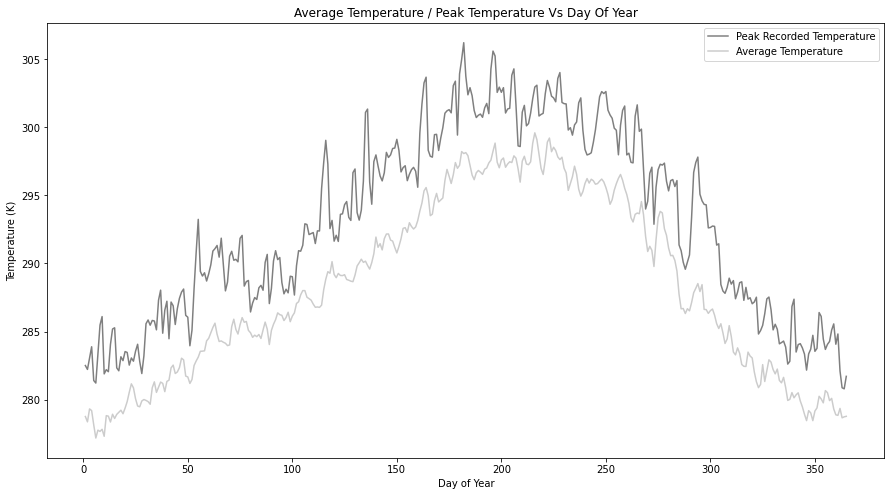

In [173]:
plot_ds_band_values(ds_avg_region, 'tasmax', 'K')